In [14]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from os import getcwd
TRAIN = os.path.join(getcwd(), 'drive/MyDrive/Colab Notebooks/Assignment/Assignment3/MinHash/data/articles_1000.train')
TRUTH = os.path.join(getcwd(), 'drive/MyDrive/Colab Notebooks/Assignment/Assignment3/MinHash/data/articles_1000.truth')

In [9]:
# mapping
# cache the index of every docid for O(1) query later
def docid_map(docids):
    docid_col_map = dict()
    for i in range(0, len(docids)):
        docid_col_map[docids[i]] = i
    return docid_col_map

In [10]:
import string

def parse_data(filename):
    if not filename:
        raise ValueError("filename is empty.")

    with open(filename) as f:
        # read lines from filename
        content = f.readlines()
        content = [x.strip() for x in content]

        exclude = set(string.punctuation)
        tuples = list()

    for line in content:
        id, article = line.split(" ", 1)

        #remove all punctuation
        #remove all whitespace so that all words are concatenated
        #change all letters to lowercase
        article = ''.join(ch for ch in article if ch not in exclude).replace(' ', '').lower()

        #construct tuple of id and text
        tuples.append((id, article))

    #return tuple with id and processed string
    return tuples

In [11]:
import binascii

def shingle_document(string, k):
    if not string:
        raise ValueError("String is empty.")
    if not k:
        raise ValueError("k is empty.")

    # initialize set data structure
    unique_hash = set()

    # extract substring of length k
    # has substring into 32-bit integer
    # insert into set
    for i in range(0, len(string) - k + 1):
        unique_hash.add(binascii.crc32(string[i:i+k].encode("utf-8")))

    # return set
    return unique_hash

In [17]:
########################
# test parse_data()
dd = parse_data(TRAIN)

In [19]:
# shingle_document()
def shingled_list(document):
    shingled_list = list()
    for d in document:
        shingled_list.append((d[0], shingle_document(d[1], 10)))
    return shingled_list

In [20]:
########################
# test shingled_list()
shingled_dd = shingled_list(dd)

In [21]:
# return ratio of union and intersection
def jaccard(a, b):
    if not a:
        raise ValueError("a is empty.")
    if not b:
        raise ValueError("b is empty.")

    a = set(a)
    b = set(b)

    # compute union size
    # compute intersection size
    return len(a.intersection(b))/len(a.union(b))

In [22]:
def similarity(filename, k):
    if not filename:
        raise ValueError("filename is empty.")
    if not k:
        raise ValueError("k is empty.")

    # parse a file with data
    tuples = parse_data(filename)
    tuples_js = list()

    n = len(tuples)

    for i in range(0, n - 1):
        id_i, article_i = tuples[i]
        if k > len(article_i):
            raise ValueError("k is out of bound.")

        for j in range(i + 1, n):
            id_j, article_j = tuples[j]
            if k > len(article_j):
                raise ValueError("k is out of bound.")

            # shingle_document()
            s = jaccard(shingle_document(article_i, k), shingle_document(article_j, k))
            tuples_js.append((id_i, id_j, s))

    # return a list of tuples, each tuple contains: (id1, id2, s)
    return tuples_js

In [ ]:
########################
# test similarity()
# similarity(TRAIN, 10)

In [23]:
# inversion

# input a list of tuples of form (id, [items])
def _invert_shingles(shingled_documents):
    if not shingled_documents:
        raise ValueError("filename is empty")

    # initialize list for tuples
    tuples = list()

    for row in shingled_documents:
        for item in row[1]:
            tuples.append((item, row[0]))
    return tuples

In [24]:
def getKey(item):
       return item[0]

In [25]:
# sorting
def invert_shingles(shingled_documents):
    if not shingled_documents:
        raise ValueError("filename is empty")
    tuples = list()

    # initialize list for document ids
    ids = list()

    for row in shingled_documents:
        ids.append(row[0])

    # invert_shingles_(), getKey()
    tuples = sorted(_invert_shingles(shingled_documents), key = getKey)

    return tuples, ids

In [26]:
############################
# test invert_shingles()
inverted = invert_shingles(shingled_dd)

In [27]:
# generate hash functions
import random

def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

def make_hashes(num_hash):
    hash_fns = list() # initialize list for hash functions

    for i in range(0, num_hash):
        hash_fns.append(make_random_hash_fn()) # make_random_hash_fn()

    return hash_fns

In [31]:
def make_minhash_signature(shingled_data, num_hashes):
    inv_index, docids = invert_shingles(shingled_data) # invert_shingles()
    num_docs = len(docids)

    docid_col_map = docid_map(docids) # docid_map
    # print(docid_col_map)

    # unique_items = {item[0] for item in inv_index}
    # sorted_unique_items = sorted(unique_items)

    # initialize the signature matrix with infinity in every entry
    sigmatrix = np.full([num_hashes, num_docs], np.inf)

    # generate hash functions
    hash_funcs = make_hashes(num_hashes) # make_hashes()

    # iterate over each non-zero entry of the characteristic matrix
    # docid locates in both characteristics matrix and signature matrix
    # row retains the row index value
    # use the same hash functions calculate through rows with the same docid and put the minimum value into sigmatrix

    for row, docid in inv_index:
        # i = row_map[row] # index of rows
        j = docid_col_map[docid] # index of columes
        for n in range(0, num_hashes):
            sigmatrix[n][j]= min(hash_funcs[n](row), sigmatrix[n][j])

    return sigmatrix

In [32]:
########################
# test make_minhash_signature()
minhash_sigmat = make_minhash_signature(shingled_dd, 2)

In [33]:
def minhash_similarity(id1, id2, minhash_sigmat):

    similarity = 0

    for i in range(0, len(minhash_sigmat)):
        if  minhash_sigmat[i][id1] == minhash_sigmat[i][id2]:
            similarity = similarity + 1

    return similarity/len(minhash_sigmat)

In [ ]:
########################
# test minhash_similarity()
# minhash_similarity(0, 0, minhash_sigmat)

In [34]:
def minhash_similarity_all(shingled_doc, num_hashes):
    inv_index, docids = invert_shingles(shingled_doc) # invert_shingles()

    MinHash_Matrix = np.zeros((len(docids), len(docids)))
    tuples = list()

    minhash_sigmat = make_minhash_signature(shingled_dd, num_hashes) # make_minhash_signature()

    docid_col_map = docid_map(docids) # docid_map()
    # print(docid_col_map)

    for d1 in docids:
        i = docid_col_map[d1]
        for d2 in docids:
            j = docid_col_map[d2]
            if i < j:
                MinHash_Matrix[i][j] = minhash_similarity(i, j, minhash_sigmat) # minhash_similarity()
                tuples.append((d1, d2, MinHash_Matrix[i][j]))

    return MinHash_Matrix, tuples

In [ ]:
########################
# test minhash_similarity_all()
# minhash_similarity_all = minhash_similarity_all(shingled_dd, 50)

In [ ]:
# minhash_similarity_matrix = minhash_similarity_all[0]
# minhash_similarity_tuples = minhash_similarity_all[1]

In [ ]:
########################
# check for consistency
# print(minhash_similarity_matrix)
# print(minhash_similarity_tuples)

In [35]:
jaccard_similarity_tuples = similarity(TRAIN, 10)
js = pd.DataFrame(jaccard_similarity_tuples)

In [36]:
js.columns = ["id1", "id2", "js"]

In [37]:
num_hashes = 100

dt = list()

for k in range(1, num_hashes + 1):

    # compare jaccard_similarity_tuples and minhash_similarity_tuples
    minhash_similarity_tuples = minhash_similarity_all(shingled_dd, k)[1]
    mh = pd.DataFrame(minhash_similarity_tuples)
    mh.columns = ["id1", "id2", "mh"]

    # all_tuples = jaccard_similarity_tuples + minhash_similarity_tuples
    # data[k-1] = (len(all_tuples) - len(set(all_tuples)))/len(jaccard_similarity_tuples)

    # use min squared error
    df = pd.merge(js, mh, on = ["id1", "id2"])
    df["diff"] = (df.js - df.mh) ** 2
    mse = df["diff"].sum()
    rmse = math.sqrt(mse/len(df))
    fraction = np.mean(js.js == mh.mh)
    num = k
    dt.append((num, rmse, fraction))

dt = pd.DataFrame(dt, columns = ["num", "rmse", "fraction"])

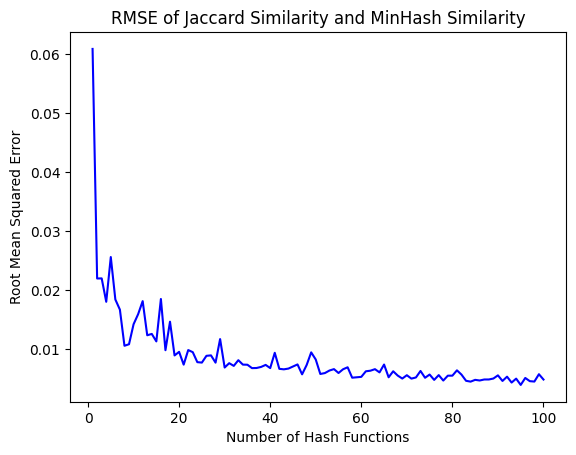

In [38]:
plt.plot(dt.num, dt.rmse, color = "blue")
plt.title("RMSE of Jaccard Similarity and MinHash Similarity")
plt.xlabel("Number of Hash Functions")
plt.ylabel("Root Mean Squared Error")
plt.show()

#### What is the effect of the number of hash functions used to compute the Minhash signature on the accuracy of the Minhash estimate of Jaccard similarity.

#### As the number of hash functions increases, the accurary of Minhash estimate of Jaccard similarity increases. The most dramatic decrease of RMSE happens around 5 for the number of hash functions, and at the x-ray of 60, RMSE levels out.